In [1]:
import pandas as pd
import numpy as np

import os
import json
import time
import re

from dateutil.relativedelta import relativedelta

from datetime import date, datetime, timedelta, timezone

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


# PRO-tip: Let's use the SVG backend to render figures in the notebook. It looks much better.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Load data

In [3]:
ALL_FEATURE_DIR = './data/all_features/'

### Mid-elo data

In [4]:
REGION = 'euw1'
TIER = 'GOLD'
DIVISION = 'I'

In [5]:
gold_eu = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [6]:
REGION = 'kr'
TIER = 'GOLD'
DIVISION = 'I'

In [7]:
gold_kr = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [8]:
# merge
mid_elo = pd.concat([gold_eu, gold_kr], axis=0)

In [9]:
mid_elo.shape

(139824, 308)

### High-elo data

Challenger

In [10]:
REGION = 'euw1'
TIER = 'CHALLENGER'
DIVISION = 'I'

In [11]:
chal_eu = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [12]:
REGION = 'kr'
TIER = 'CHALLENGER'
DIVISION = 'I'

In [13]:
chal_kr = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

Grandmaster

In [14]:
REGION = 'euw1'
TIER = 'GRANDMASTER'
DIVISION = 'I'

In [15]:
gm_eu = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [16]:
REGION = 'kr'
TIER = 'GRANDMASTER'
DIVISION = 'I'

In [17]:
gm_kr = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

Merge

In [18]:
high_elo = pd.concat([chal_eu, chal_kr, gm_eu, gm_kr], axis=0)

In [19]:
high_elo.shape

(198496, 308)

## 2. Exploratory data analysis

### Game length

In [20]:
# get game length of matches in mid vs. high elo
mid_length = mid_elo.groupby('metadata_match_id').agg({'info_game_length': 'mean'}).reset_index()
high_length = high_elo.groupby('metadata_match_id').agg({'info_game_length': 'mean'}).reset_index()

In [21]:
stats.ttest_ind(mid_length['info_game_length'], high_length['info_game_length'], alternative='greater')

TtestResult(statistic=37.64243052340942, pvalue=2.4393684752330294e-305, df=42288.0)

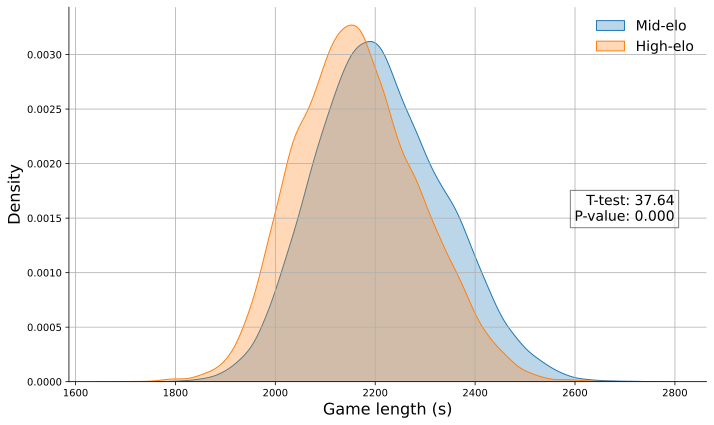

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# plot distribution of game length in mid vs. high elo
sns.kdeplot(data=mid_length['info_game_length'], ax=ax, label='Mid-elo', fill=True, alpha=.3)
sns.kdeplot(data=high_length['info_game_length'], ax=ax, label='High-elo', fill=True, alpha=.3)

# compare the average game length across 2 elos
t, p = stats.ttest_ind(mid_length['info_game_length'], high_length['info_game_length'], alternative='greater')

ax.legend(frameon=False, fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Game length (s)', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.grid(True, axis='both')

# Display t-test statistic and p-value on the plot
textstr = f'T-test: {t:.2f}\nP-value: {p:.3f}'
ax.text(0.95, 0.5, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.tight_layout()
plt.show()

### Gold left

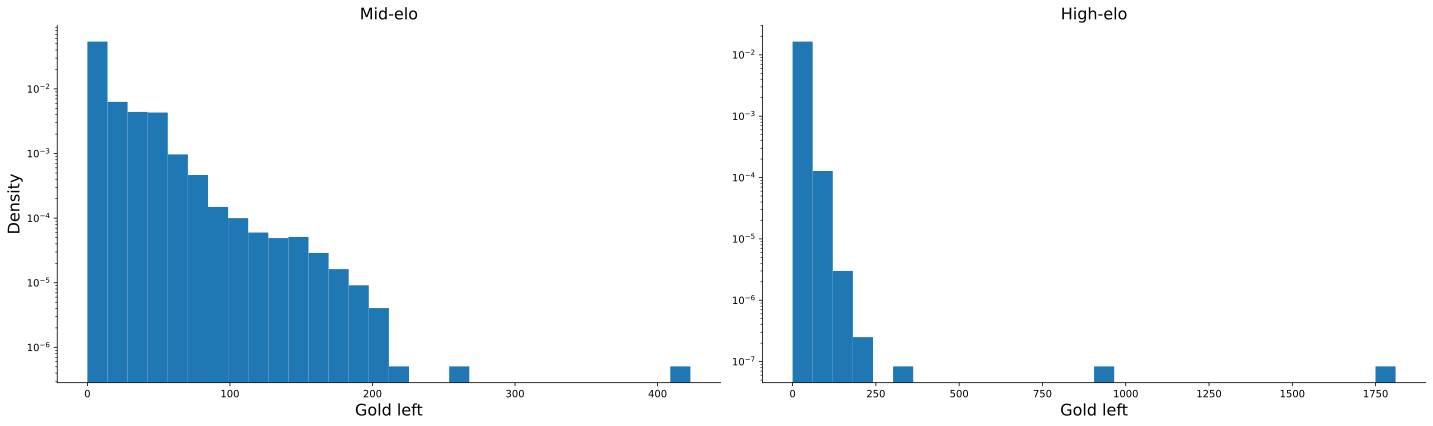

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

ax[0].hist(mid_elo['gold_left'], bins=30, density=True)
ax[1].hist(high_elo['gold_left'], bins=30, density=True)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

# ax[0].set_xscale('log')
# ax[1].set_xscale('log')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_ylabel('Density', fontsize=16)
ax[0].set_xlabel('Gold left', fontsize=16)
ax[1].set_xlabel('Gold left', fontsize=16)

ax[0].set_title('Mid-elo', fontsize=16)
ax[1].set_title('High-elo', fontsize=16)

plt.tight_layout()
plt.show()

### Total board cost vs. placement

In [24]:
# compare the average total board cost across 2 elos
stats.mannwhitneyu(mid_elo['total_board_cost'], high_elo['total_board_cost'], alternative='less')

MannwhitneyuResult(statistic=12804003437.0, pvalue=0.0)

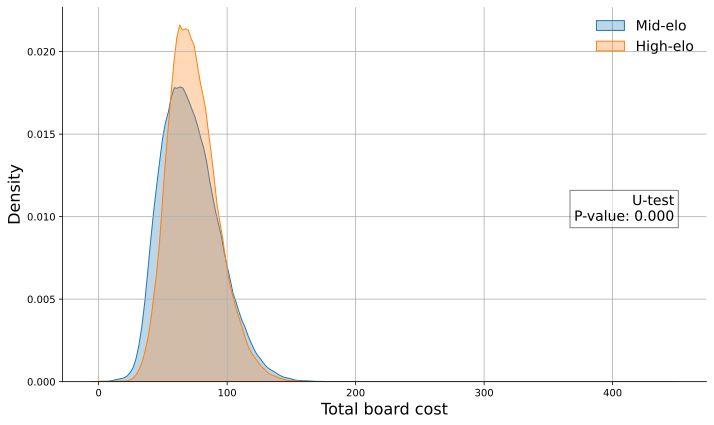

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# plot distribution of game length in mid vs. high elo
sns.kdeplot(data=mid_elo['total_board_cost'], ax=ax, label='Mid-elo', fill=True, alpha=.3)
sns.kdeplot(data=high_elo['total_board_cost'], ax=ax, label='High-elo', fill=True, alpha=.3)

# compare the average total board cost across 2 elos
u, p = stats.mannwhitneyu(mid_elo['total_board_cost'], high_elo['total_board_cost'], alternative='less')

ax.legend(frameon=False, fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Total board cost', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.grid(True, axis='both')

# Display u-test statistic and p-value on the plot
textstr = f'U-test\nP-value: {p:.3f}'
ax.text(0.95, 0.5, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.tight_layout()
plt.show()

High-elo players on average play more 'expensive' boards (could be higher cost units or they are hitting more 3 star 3-cost units)

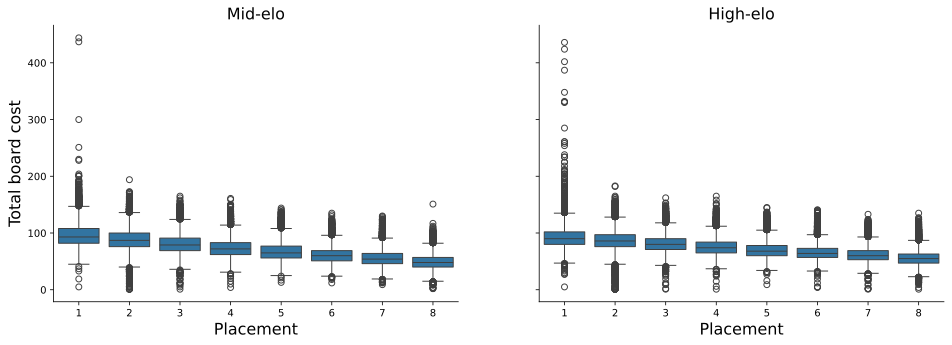

In [26]:
# comparing board cost across different placements
fig, ax = plt.subplots(1, 2, figsize=(16,5), sharey=True)

sns.boxplot(x="placement", y="total_board_cost", data=mid_elo, ax=ax[0])
sns.boxplot(x='placement', y='total_board_cost', data=high_elo, ax=ax[1])

ax[0].set_ylabel('Total board cost', fontsize=16)
ax[0].set_xlabel('Placement', fontsize=16)
ax[1].set_xlabel('Placement', fontsize=16)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_title('Mid-elo', fontsize=16)
ax[1].set_title('High-elo', fontsize=16)

# plt.tight_layout()
plt.show()

Across both mid and high elo, we see that the total board cost on average increases as the players reach higher placement (towards top 1).

### Unit popularity & win rate

Do popular units in mid elo stay popular in high elo? Do high win rate of units vary across elos?

In [27]:
mid_champs = mid_elo[['metadata_match_id', 'puuid', 'units', 'win']]
high_champs = high_elo[['metadata_match_id', 'puuid', 'units', 'win']]

In [28]:
mid_champs['unit_name'] = mid_champs['units'].apply(lambda x: set([i['unit_name'] for i in x]))
high_champs['unit_name'] = high_champs['units'].apply(lambda x: set([i['unit_name'] for i in x]))

/tmp/ipykernel_18053/2017284147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_champs['unit_name'] = mid_champs['units'].apply(lambda x: set([i['unit_name'] for i in x]))
/tmp/ipykernel_18053/2017284147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_champs['unit_name'] = high_champs['units'].apply(lambda x: set([i['unit_name'] for i in x]))


In [29]:
# calculate unit frequencies
mid_unit_freq = (mid_champs.explode('unit_name')
                             .groupby(['metadata_match_id', 'puuid'])['unit_name'].value_counts().reset_index()
                             .groupby('unit_name')[['metadata_match_id', 'puuid']].count()
                             .drop('metadata_match_id', axis=1)
                             .rename(columns={'puuid': 'play_count'})
                )
mid_unit_freq['mid_elo'] = mid_unit_freq['play_count'] / mid_elo.shape[0]
mid_unit_freq.drop('play_count', axis=1, inplace=True)

high_unit_freq = (high_champs.explode('unit_name')
                             .groupby(['metadata_match_id', 'puuid'])['unit_name'].value_counts().reset_index()
                             .groupby('unit_name')[['metadata_match_id', 'puuid']].count()
                             .drop('metadata_match_id', axis=1)
                             .rename(columns={'puuid': 'play_count'})
                )
high_unit_freq['high_elo'] = high_unit_freq['play_count'] / high_elo.shape[0]
high_unit_freq.drop('play_count', axis=1, inplace=True)

In [30]:
mid_unit_freq.head()

,mid_elo
unit_name,
Akali,0.112842
Ambessa,0.205687
Amumu,0.113250
Black Rose Sion,0.125637
Blitzcrank,0.095270


In [31]:
unit_freq = pd.merge(mid_unit_freq, high_unit_freq, on='unit_name', how='left')

In [32]:
unit_freq.head()

,mid_elo,high_elo
unit_name,,
Akali,0.112842,0.074586
Ambessa,0.205687,0.237098
Amumu,0.113250,0.050721
Black Rose Sion,0.125637,0.128718
Blitzcrank,0.095270,0.034640


In [33]:
unit_freq.shape

(65, 2)

In [34]:
with open('./data/data_dragon/set13/units.json', 'r') as file:
    set13_units = json.load(file)

In [35]:
unit_cost = {set13_units[i]['name']: set13_units[i]['tier'] for i in set13_units}

In [36]:
unit_freq['unit_cost'] = unit_freq.index.map(unit_cost)

In [37]:
unit_freq.head()

,mid_elo,high_elo,unit_cost
unit_name,,,
Akali,0.112842,0.074586,2.0
Ambessa,0.205687,0.237098,4.0
Amumu,0.113250,0.050721,1.0
Black Rose Sion,0.125637,0.128718,NaN
Blitzcrank,0.095270,0.034640,3.0


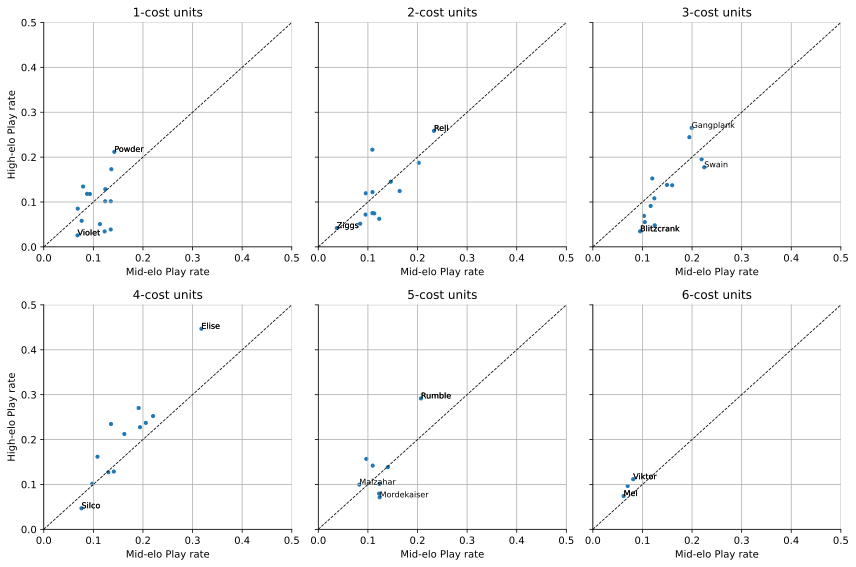

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey=True)
ax = ax.ravel()
for i in range(1, 7):
    ax[i-1].scatter(unit_freq[unit_freq['unit_cost']==i]['mid_elo'], unit_freq[unit_freq['unit_cost']==i]['high_elo'], s=10)
    ax[i-1].set_xlim(0, 0.5)
    ax[i-1].set_ylim(0, 0.5)
    ax[i-1].plot(np.linspace(0, 0.5, 100), np.linspace(0, 0.5, 100), color='k', linestyle='--', linewidth=0.8)
    ax[i-1].set_xlabel('Mid-elo Play rate')
    if (i-1) % 3 == 0:
        ax[i-1].set_ylabel('High-elo Play rate')
    ax[i-1].set_title(f'{i}-cost units')
    ax[i-1].spines['top'].set_visible(False)
    ax[i-1].spines['right'].set_visible(False)
    ax[i-1].grid(True)

    mid_highest = unit_freq[unit_freq['unit_cost']==i]['mid_elo'].idxmax()
    high_highest = unit_freq[unit_freq['unit_cost']==i]['high_elo'].idxmax()

    mid_lowest = unit_freq[unit_freq['unit_cost']==i]['mid_elo'].idxmin()
    high_lowest = unit_freq[unit_freq['unit_cost']==i]['high_elo'].idxmin()

    for j in [mid_highest, mid_lowest, high_highest, high_lowest]:
        ax[i-1].text(unit_freq.loc[j, 'mid_elo'], unit_freq.loc[j, 'high_elo'], j, ha='left', fontsize=8)



plt.tight_layout()
plt.show()

Generally, 4-cost units have higher play rates in high elo compared to mid elo. 3-cost units generally have higher play rates in mid-elo compared to high-elo.

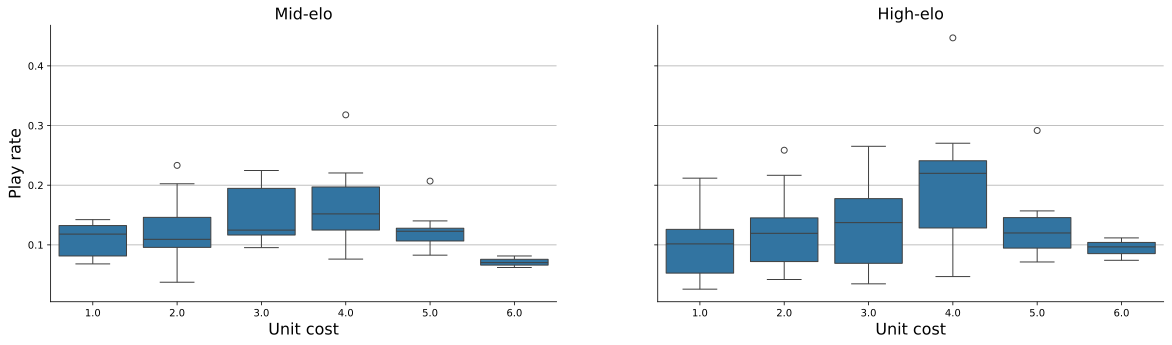

In [39]:
# comparing pick rate of different unit costs in mid vs. high elo
fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.boxplot(x="unit_cost", y="mid_elo", data=unit_freq[~unit_freq['unit_cost'].isnull()], ax=ax[0])
sns.boxplot(x='unit_cost', y='high_elo', data=unit_freq[~unit_freq['unit_cost'].isnull()], ax=ax[1])

ax[0].set_ylabel('Play rate', fontsize=16)
ax[0].set_xlabel('Unit cost', fontsize=16)
ax[1].set_xlabel('Unit cost', fontsize=16)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_title('Mid-elo', fontsize=16)
ax[1].set_title('High-elo', fontsize=16)

ax[0].grid(True, axis='y')
ax[1].grid(True, axis='y')

# plt.tight_layout()
plt.show()

Play rate of 4 cost units are higher in high-elo than in low-elo

In [40]:
# calculating win rate per units
mid_champ_winrate = mid_champs.explode('unit_name').groupby('unit_name')['win'].mean()
high_champ_winrate = high_champs.explode('unit_name').groupby('unit_name')['win'].mean()

In [41]:
mid_champ_winrate.sort_values(ascending=False)

unit_name
Mel                0.778021
Viktor             0.767235
Warwick            0.763788
Caitlyn            0.663486
LeBlanc            0.654885
Malzahar           0.651993
Rumble             0.638199
Jayce              0.614765
Jayce's summons    0.614518
Jinx               0.592833
Sevika             0.583119
Mordekaiser        0.576716
Black Rose Sion    0.559230
Ekko               0.556640
Elise              0.546633
Garen              0.544326
Vi                 0.541478
Illaoi             0.541254
Zoe                0.538212
Corki              0.532376
Nami               0.532343
Twisted Fate       0.531998
Loris              0.527215
Amumu              0.526302
Camille            0.525074
Heimerdinger       0.522810
Scar               0.522755
Ambessa            0.519680
Steb               0.517152
Morgana            0.517144
Maddie             0.515645
Kog'Maw            0.514561
Cassiopeia         0.513763
Vladimir           0.512826
Zeri               0.512649
Twitch    

In [42]:
unit_winrate = pd.concat([mid_champ_winrate, high_champ_winrate], axis=1, keys=['mid_elo', 'high_elo'])

In [43]:
unit_winrate.head()

,mid_elo,high_elo
unit_name,,
Akali,0.494613,0.495441
Ambessa,0.519680,0.511463
Amumu,0.526302,0.495332
Black Rose Sion,0.559230,0.579452
Blitzcrank,0.478117,0.478330


In [44]:
unit_winrate['unit_cost'] = unit_winrate.index.map(unit_cost)

In [45]:
unit_winrate.head()

,mid_elo,high_elo,unit_cost
unit_name,,,
Akali,0.494613,0.495441,2.0
Ambessa,0.519680,0.511463,4.0
Amumu,0.526302,0.495332,1.0
Black Rose Sion,0.559230,0.579452,NaN
Blitzcrank,0.478117,0.478330,3.0


In [46]:
unit_winrate[unit_winrate['unit_cost']==1]['high_elo']

unit_name
Amumu      0.495332
Darius     0.439028
Draven     0.429700
Irelia     0.496505
Lux        0.449294
Maddie     0.462053
Morgana    0.511982
Powder     0.482216
Singed     0.515556
Steb       0.487851
Trundle    0.466237
Vex        0.491487
Violet     0.463017
Zyra       0.509439
Name: high_elo, dtype: float64

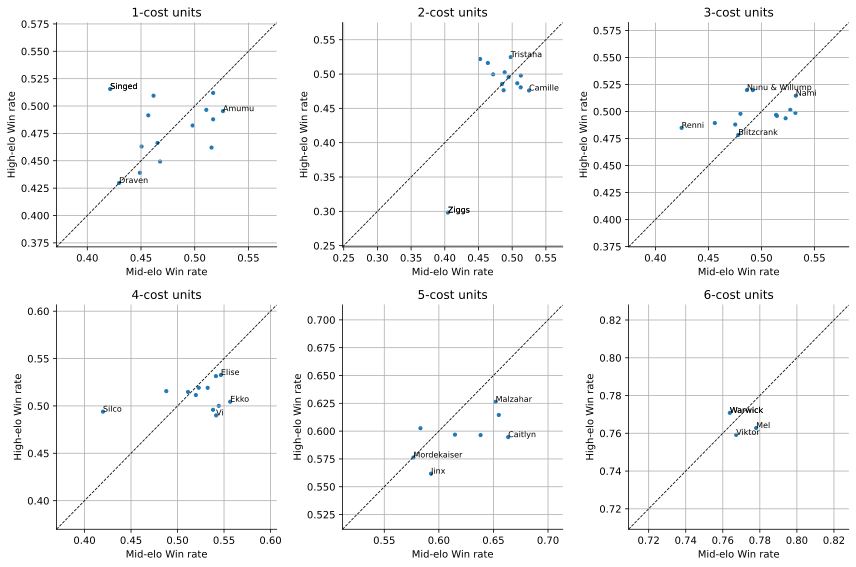

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax = ax.ravel()
for i in range(1, 7):
    ax[i-1].scatter(unit_winrate[unit_winrate['unit_cost']==i]['mid_elo'], unit_winrate[unit_winrate['unit_cost']==i]['high_elo'], s=10)
    lmin = min(unit_winrate[unit_winrate['unit_cost']==i]['mid_elo'].min(), unit_winrate[unit_winrate['unit_cost']==i]['high_elo'].min()) - 0.05
    lmax = max(unit_winrate[unit_winrate['unit_cost']==i]['mid_elo'].max(), unit_winrate[unit_winrate['unit_cost']==i]['high_elo'].max()) + 0.05
    ax[i-1].set_xlim(lmin, lmax)
    ax[i-1].set_ylim(lmin, lmax)
    x_ = unit_winrate[unit_winrate['unit_cost']==i]['mid_elo']
    ax[i-1].plot(np.linspace(lmin, lmax, 100), np.linspace(lmin, lmax, 100), color='k', linestyle='--', linewidth=0.8)
    ax[i-1].set_xlabel('Mid-elo Win rate')
    ax[i-1].set_ylabel('High-elo Win rate')
    ax[i-1].set_title(f'{i}-cost units')
    ax[i-1].spines['top'].set_visible(False)
    ax[i-1].spines['right'].set_visible(False)
    
    # show highest winrate unit in mid vs high elo of this cost
    mid_highest = unit_winrate[unit_winrate['unit_cost']==i]['mid_elo'].idxmax()
    mid_lowest = unit_winrate[unit_winrate['unit_cost']==i]['mid_elo'].idxmin()
    high_highest = unit_winrate[unit_winrate['unit_cost']==i]['high_elo'].idxmax()
    high_lowest = unit_winrate[unit_winrate['unit_cost']==i]['high_elo'].idxmin()

    for unit in [mid_highest, mid_lowest, high_highest, high_lowest]:
        ax[i-1].text(unit_winrate.loc[unit, 'mid_elo'], unit_winrate.loc[unit, 'high_elo'], unit, ha='left', fontsize=8)
    # if mid_lowest != high_lowest:
    #     ax[i-1].text(unit_winrate.loc[high_lowest, 'mid_elo']+.005, unit_winrate.loc[high_lowest, 'high_elo'], high_lowest, ha='left')

    ax[i-1].grid(True)
plt.tight_layout()

plt.show()

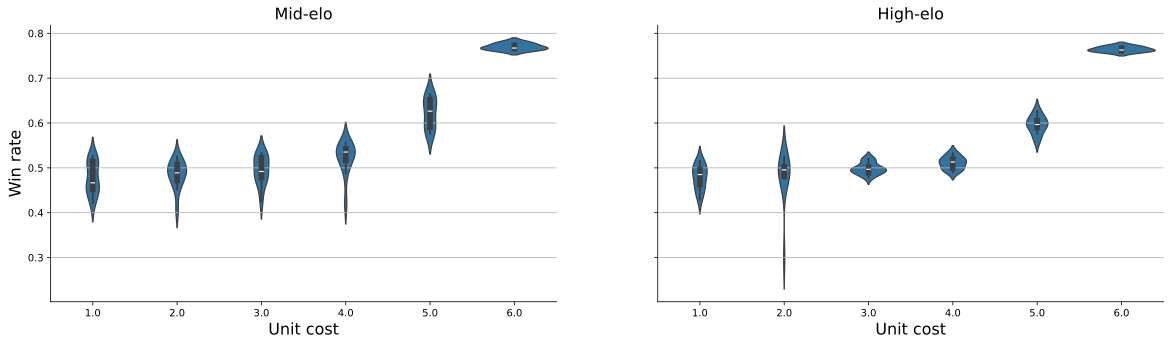

In [48]:
# comparing win rate of different unit costs in mid vs. high elo
fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.violinplot(x="unit_cost", y="mid_elo", data=unit_winrate[~unit_winrate['unit_cost'].isnull()], ax=ax[0])
sns.violinplot(x='unit_cost', y='high_elo', data=unit_winrate[~unit_winrate['unit_cost'].isnull()], ax=ax[1])

# ax[0].set_ylim(0.0, 1.0)

ax[0].set_ylabel('Win rate', fontsize=16)
ax[0].set_xlabel('Unit cost', fontsize=16)
ax[1].set_xlabel('Unit cost', fontsize=16)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_title('Mid-elo', fontsize=16)
ax[1].set_title('High-elo', fontsize=16)

ax[0].grid(True, axis='y')
ax[1].grid(True, axis='y')

# plt.tight_layout()
plt.show()

In [49]:
# compare average win rate of different unit costs in mid vs. high elo
for i in range(1, 7):
    mid_ = unit_winrate[unit_winrate['unit_cost']==i]['mid_elo']
    high_ = unit_winrate[unit_winrate['unit_cost']==i]['high_elo']
    u, p = stats.mannwhitneyu(mid_, high_, alternative='greater')
    print(f'{i}-cost units:')
    print(f'U-statistics: {u}, p-value: {p}')
    print()

1-cost units:
U-statistics: 101.0, p-value: 0.45427439908546097

2-cost units:
U-statistics: 77.0, p-value: 0.6591910678634583

3-cost units:
U-statistics: 79.0, p-value: 0.6208417632368548

4-cost units:
U-statistics: 108.0, p-value: 0.020202059794111847

5-cost units:
U-statistics: 45.0, p-value: 0.09743589743589742

6-cost units:
U-statistics: 7.0, p-value: 0.2



In [50]:
# compare average win rate of different unit costs in mid vs. high elo
for i in range(1, 7):
    mid_ = unit_winrate[unit_winrate['unit_cost']==i]['mid_elo']
    high_ = unit_winrate[unit_winrate['unit_cost']==i]['high_elo']
    ks, p = stats.ks_2samp(mid_, high_)
    print(f'{i}-cost units:')
    print(f'KS-statistics: {ks}, p-value: {p}')
    print()

1-cost units:
KS-statistics: 0.2857142857142857, p-value: 0.6354849613377005

2-cost units:
KS-statistics: 0.23076923076923078, p-value: 0.8978057035171046

3-cost units:
KS-statistics: 0.3076923076923077, p-value: 0.5881960656115993

4-cost units:
KS-statistics: 0.5833333333333334, p-value: 0.031436056203858066

5-cost units:
KS-statistics: 0.5, p-value: 0.2826728826728826

6-cost units:
KS-statistics: 0.6666666666666666, p-value: 0.6



Win rate of 5-cost units in mid-elo seems to be higher on average than in high-elo, but there is more variance. There is also more variance in winrate of lower cost units in mid-elo (1, 2, 3 cost)

### Trait popularity & winrate

In [51]:
mid_traits = mid_elo[['metadata_match_id', 'puuid', 'active_traits', 'win']]
high_traits = high_elo[['metadata_match_id', 'puuid', 'active_traits', 'win']]

In [52]:
mid_traits = mid_traits.explode('active_traits')
high_traits = high_traits.explode('active_traits')

In [53]:
mid_traits.head()

,metadata_match_id,puuid,active_traits,win
0,EUW1_7277895332,kJlXhqjGxt-oo50Nwm4Cv6psUslwqUtt8kGQnbI9Kw4rDp...,"{'trait_name': 'Emissary', 'trait_style': 1.0,...",0
0,EUW1_7277895332,kJlXhqjGxt-oo50Nwm4Cv6psUslwqUtt8kGQnbI9Kw4rDp...,"{'trait_name': 'Automata', 'trait_style': 2.0,...",0
0,EUW1_7277895332,kJlXhqjGxt-oo50Nwm4Cv6psUslwqUtt8kGQnbI9Kw4rDp...,"{'trait_name': 'Sniper', 'trait_style': 1.0, '...",0
0,EUW1_7277895332,kJlXhqjGxt-oo50Nwm4Cv6psUslwqUtt8kGQnbI9Kw4rDp...,"{'trait_name': 'Watcher', 'trait_style': 1.0, ...",0
1,EUW1_7277898823,0NErAUw926_wzGCJlGtpK3NR17GnTzNJnWNsH7J8mMnuKo...,"{'trait_name': 'Emissary', 'trait_style': 1.0,...",1


In [54]:
mid_traits['trait_name'] = mid_traits['active_traits'].apply(lambda x: x['trait_name'] if isinstance(x, dict) else None)
mid_traits['trait_style'] = mid_traits['active_traits'].apply(lambda x: x['trait_style'] if isinstance(x, dict) else None)
mid_traits['is_vertical_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_vertical_trait'] if isinstance(x, dict) else None)
mid_traits['is_horizontal_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_horizontal_trait'] if isinstance(x, dict) else None)
mid_traits['is_econ_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_econ_trait'] if isinstance(x, dict) else None)
mid_traits['is_offensive_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_offensive_trait'] if isinstance(x, dict) else None)
mid_traits['is_defensive_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_defensive_trait'] if isinstance(x, dict) else None)
mid_traits['is_utility_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_utility_trait'] if isinstance(x, dict) else None)
mid_traits['is_unique_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_unique_trait'] if isinstance(x, dict) else None)
mid_traits['is_teamup_trait'] = mid_traits['active_traits'].apply(lambda x: x['is_teamup_trait'] if isinstance(x, dict) else None)

high_traits['trait_name'] = high_traits['active_traits'].apply(lambda x: x['trait_name'] if isinstance(x, dict) else None)
high_traits['trait_style'] = high_traits['active_traits'].apply(lambda x: x['trait_style'] if isinstance(x, dict) else None)
high_traits['is_vertical_trait'] = high_traits['active_traits'].apply(lambda x: x['is_vertical_trait'] if isinstance(x, dict) else None)
high_traits['is_horizontal_trait'] = high_traits['active_traits'].apply(lambda x: x['is_horizontal_trait'] if isinstance(x, dict) else None)
high_traits['is_econ_trait'] = high_traits['active_traits'].apply(lambda x: x['is_econ_trait'] if isinstance(x, dict) else None)
high_traits['is_offensive_trait'] = high_traits['active_traits'].apply(lambda x: x['is_offensive_trait'] if isinstance(x, dict) else None)
high_traits['is_defensive_trait'] = high_traits['active_traits'].apply(lambda x: x['is_defensive_trait'] if isinstance(x, dict) else None)
high_traits['is_utility_trait'] = high_traits['active_traits'].apply(lambda x: x['is_utility_trait'] if isinstance(x, dict) else None)
high_traits['is_unique_trait'] = high_traits['active_traits'].apply(lambda x: x['is_unique_trait'] if isinstance(x, dict) else None)
high_traits['is_teamup_trait'] = high_traits['active_traits'].apply(lambda x: x['is_teamup_trait'] if isinstance(x, dict) else None)

Trait play rate

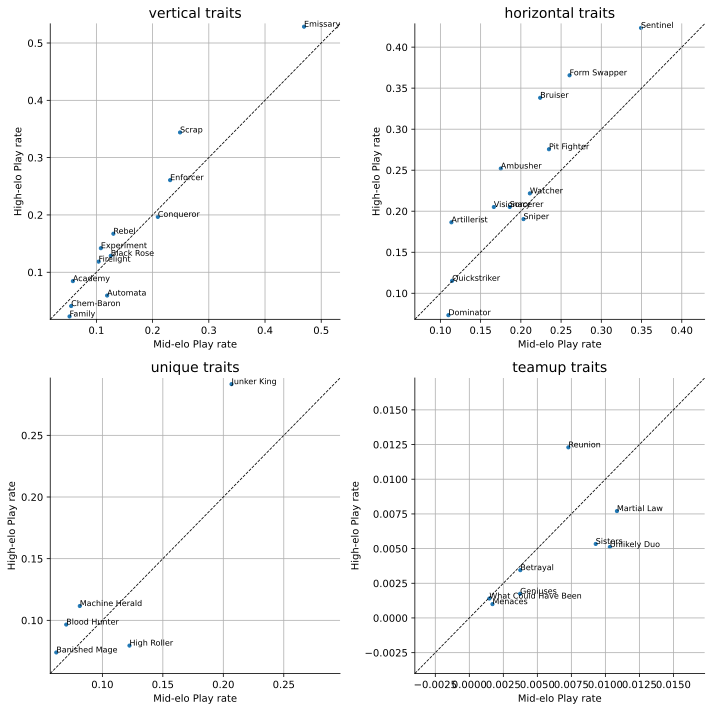

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
ax = ax.ravel()
for i, char in enumerate(['vertical', 'horizontal', 'unique', 'teamup']):
    trait_char = f'is_{char}_trait'
    ############ calculate trait playrate ##############
    mid_trait_freq = (mid_traits[mid_traits[trait_char]==1].groupby(['metadata_match_id', 'puuid'])['trait_name'].value_counts().reset_index()
                                .groupby('trait_name')[['metadata_match_id', 'puuid']].count()
                                .drop('metadata_match_id', axis=1)
                                .rename(columns={'puuid': 'play_count'})
                     )
    
    mid_trait_freq['mid_elo'] = mid_trait_freq['play_count'] / mid_elo.shape[0]
    mid_trait_freq.drop('play_count', axis=1, inplace=True)
    
    high_trait_freq = (high_traits[high_traits[trait_char]==1].groupby(['metadata_match_id', 'puuid'])['trait_name'].value_counts().reset_index()
                                .groupby('trait_name')[['metadata_match_id', 'puuid']].count()
                                .drop('metadata_match_id', axis=1)
                                .rename(columns={'puuid': 'play_count'})
                     )
    
    high_trait_freq['high_elo'] = high_trait_freq['play_count'] / high_elo.shape[0]
    high_trait_freq.drop('play_count', axis=1, inplace=True)

    trait_freq = pd.merge(mid_trait_freq, high_trait_freq, on='trait_name', how='left')

    ######### plot trait play rate ##############
    ax[i].scatter(trait_freq['mid_elo'], trait_freq['high_elo'], s=10)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    ax[i].set_ylabel('High-elo Play rate')
    ax[i].set_xlabel('Mid-elo Play rate')
    ax[i].set_title(f'{char} traits', fontsize=14)

    lmin = min(trait_freq['mid_elo'].min(), trait_freq['high_elo'].min())
    lmax = max(trait_freq['mid_elo'].max(), trait_freq['high_elo'].max())
    
    ax[i].set_xlim(lmin-0.005, lmax+0.005)
    ax[i].set_ylim(lmin-0.005, lmax+0.005)
    
    ax[i].plot(np.linspace(lmin-0.005, lmax+0.005, 100), np.linspace(lmin-0.005, lmax+0.005, 100), 'k--', linewidth=0.8)

    for trait in trait_freq.index:
        ax[i].text(trait_freq.loc[trait, 'mid_elo'], trait_freq.loc[trait, 'high_elo'], trait, ha='left', fontsize=8)

    ax[i].grid(True)

plt.tight_layout()
plt.show()

Trait win rate

In [56]:
mid_trait_wr = mid_traits.groupby('trait_name').agg(mid_elo=('win', 'mean'))
high_trait_wr = high_traits.groupby('trait_name').agg(high_elo=('win', 'mean'))

trait_wr = pd.merge(mid_trait_wr, high_trait_wr, on='trait_name', how='left')

trait_wr.head()

,mid_elo,high_elo
trait_name,,
Academy,0.523119,0.514812
Ambusher,0.530457,0.498671
Artillerist,0.499717,0.513495
Automata,0.533145,0.537926
Banished Mage,0.777675,0.762145


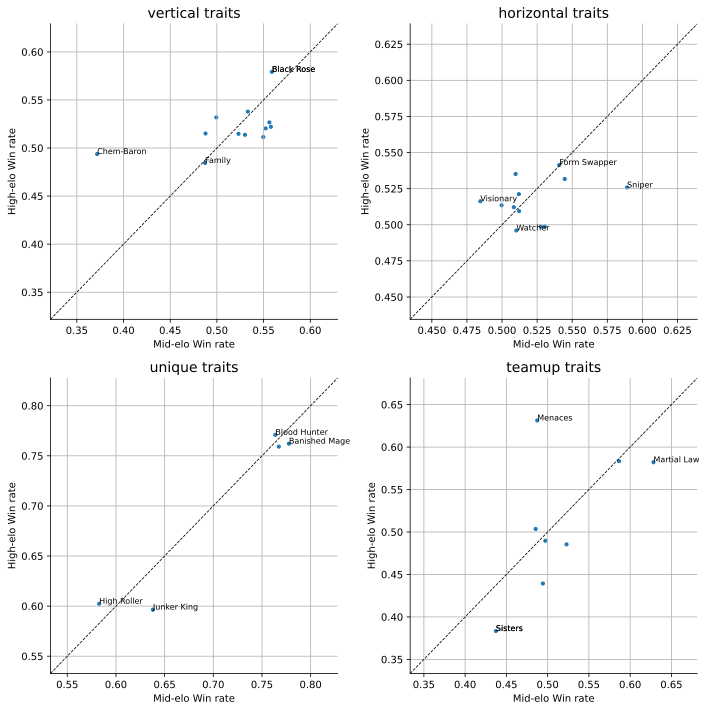

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
ax = ax.ravel()
for i, char in enumerate(['vertical', 'horizontal', 'unique', 'teamup']):
    trait_char = f'is_{char}_trait'
    ############ calculate trait winrate ##############
    mid_trait_wr = mid_traits[mid_traits[trait_char]==1].groupby('trait_name').agg(mid_elo=('win', 'mean'))
    high_trait_wr = high_traits[high_traits[trait_char]==1].groupby('trait_name').agg(high_elo=('win', 'mean'))

    trait_wr = pd.merge(mid_trait_wr, high_trait_wr, on='trait_name', how='left')

    ######### plot trait play rate ##############
    ax[i].scatter(trait_wr['mid_elo'], trait_wr['high_elo'], s=10)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    ax[i].set_ylabel('High-elo Win rate')
    ax[i].set_xlabel('Mid-elo Win rate')
    ax[i].set_title(f'{char} traits', fontsize=14)

    lmin = min(trait_wr['mid_elo'].min(), trait_wr['high_elo'].min())
    lmax = max(trait_wr['mid_elo'].max(), trait_wr['high_elo'].max())
    
    ax[i].set_xlim(lmin-0.05, lmax+0.05)
    ax[i].set_ylim(lmin-0.05, lmax+0.05)
    
    ax[i].plot(np.linspace(lmin-0.05, lmax+0.05, 100), np.linspace(lmin-0.05, lmax+0.05, 100), 'k--', linewidth=0.8)

    # highest and lowest winrate traits in mid vs. high elo
    mid_highest = trait_wr['mid_elo'].idxmax()
    mid_lowest = trait_wr['mid_elo'].idxmin()
    high_highest = trait_wr['high_elo'].idxmax()
    high_lowest = trait_wr['high_elo'].idxmin()

    for trait in [mid_highest, mid_lowest, high_highest, high_lowest]:
        ax[i].text(trait_wr.loc[trait, 'mid_elo'], trait_wr.loc[trait, 'high_elo'], trait, ha='left', fontsize=8)

    ax[i].grid(True)

plt.tight_layout()
plt.show()

### Level

In [58]:
stats.mannwhitneyu(mid_elo['level'], high_elo['level'], alternative='less')

MannwhitneyuResult(statistic=12150578159.5, pvalue=0.0)

In [59]:
mid_elo['level'].median(), high_elo['level'].median()

(8.0, 8.0)

<Axes: ylabel='Frequency'>

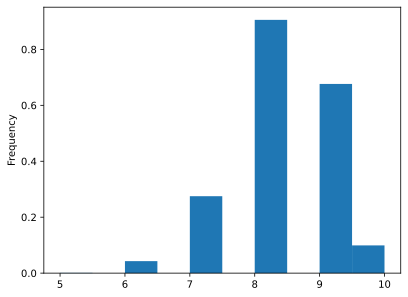

In [60]:
mid_elo['level'].plot.hist(density=True)

<Axes: ylabel='Frequency'>

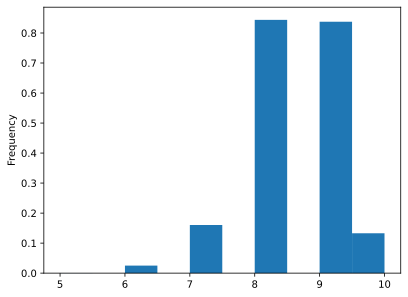

In [61]:
high_elo['level'].plot.hist(density=True)

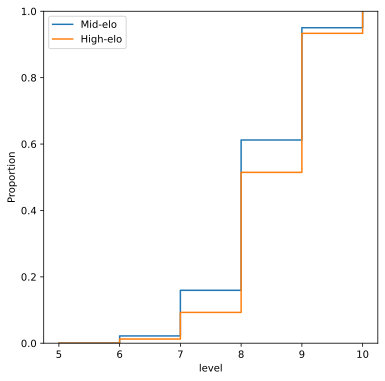

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.ecdfplot(data=mid_elo, x="level", ax=ax, label='Mid-elo')
sns.ecdfplot(data=high_elo, x="level", ax=ax, label='High-elo')

ax.legend()

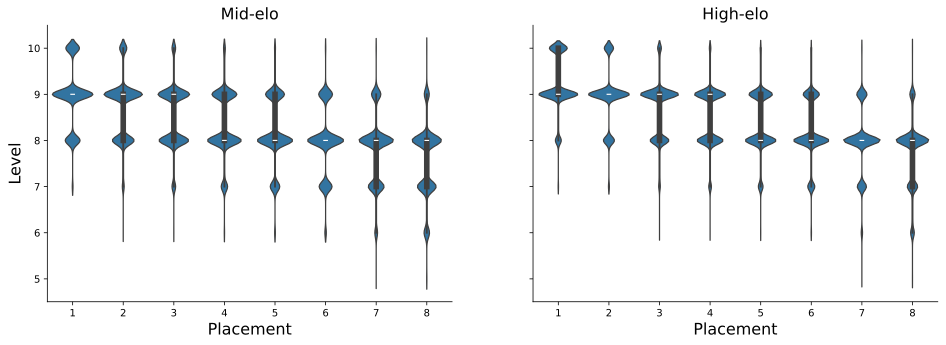

In [63]:
# comparing board cost across different placements
fig, ax = plt.subplots(1, 2, figsize=(16,5), sharey=True)

sns.violinplot(x="placement", y="level", data=mid_elo, ax=ax[0])
sns.violinplot(x='placement', y='level', data=high_elo, ax=ax[1])

ax[0].set_ylabel('Level', fontsize=16)
ax[0].set_xlabel('Placement', fontsize=16)
ax[1].set_xlabel('Placement', fontsize=16)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_title('Mid-elo', fontsize=16)
ax[1].set_title('High-elo', fontsize=16)

# plt.tight_layout()
plt.show()

### Total tier-3 units

In [64]:
mid_elo['total_tier_3_units'].value_counts(normalize=True).sort_index(ascending=True)

total_tier_3_units
0    0.456338
1    0.245573
2    0.148758
3    0.082625
4    0.041667
5    0.018774
6    0.005514
7    0.000658
8    0.000086
9    0.000007
Name: proportion, dtype: float64

In [65]:
high_elo['total_tier_3_units'].value_counts(normalize=True).sort_index(ascending=True)

total_tier_3_units
0     0.567482
1     0.157056
2     0.121877
3     0.078692
4     0.048867
5     0.022368
6     0.003260
7     0.000343
8     0.000025
9     0.000010
10    0.000010
11    0.000005
13    0.000005
Name: proportion, dtype: float64